In [ ]:
!pip install nltk indic-transliteration

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.6/155.6 kB 5.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import re
import torch
from torch.utils.data import Dataset
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.preprocessing import LabelEncoder
from indic_transliteration.sanscript import transliterate, DEVANAGARI, ITRANS
from nltk.tokenize import word_tokenize
import nltk

# Download NLTK punkt tokenizer
nltk.download("punkt_tab")

# Load data
train_df = pd.read_csv("/content/drive/MyDrive/FinalTrainingOnly.tsv", sep="\t", names=["uid", "text", "label"], header=None)
val_df = pd.read_csv("/content/drive/MyDrive/ValidationOnly.tsv", sep="\t", names=["uid", "text", "label"], header=None)
test_df = pd.read_csv("/content/drive/MyDrive/FinalTest.tsv", sep="\t", names=["uid", "text"], header=None)

# Function to detect Hindi script
def is_devanagari(word):
    return any('\u0900' <= ch <= '\u097F' for ch in word)

# Preprocessing function: clean + transliterate + tag
def preprocess(text):
    text = str(text)
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F" u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF" u"\U0001F1E0-\U0001F1FF"
        u"\U00002700-\U000027BF" u"\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE)
    text = emoji_pattern.sub('', text)
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@\w+", " ", text)
    text = re.sub(r"#\w+", " ", text)
    text = re.sub(r"[^\w\s\u0900-\u097F]", "", text)
    text = re.sub(r"\s+", " ", text).strip()

    tokens = word_tokenize(text)
    processed = []
    for word in tokens:
        if is_devanagari(word):
            translit = transliterate(word, DEVANAGARI, ITRANS)
            processed.append(f"[hin] {translit}")
        elif word.isalpha():
            processed.append(f"[en] {word.lower()}")
        else:
            processed.append(f"[oth] {word}")
    return " ".join(processed)

# Apply preprocessing
train_df["text"] = train_df["text"].apply(preprocess)
val_df["text"] = val_df["text"].apply(preprocess)
test_df["text"] = test_df["text"].apply(preprocess)

# Label encoding
le = LabelEncoder()
train_df["label"] = le.fit_transform(train_df["label"])
val_df["label"] = le.transform(val_df["label"])

# Tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")

# Dataset class
class HinglishDataset(Dataset):
    def __init__(self, texts, labels=None):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=128)
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        if self.labels is not None:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

# Create datasets
train_dataset = HinglishDataset(train_df["text"].tolist(), train_df["label"].tolist())
val_dataset = HinglishDataset(val_df["text"].tolist(), val_df["label"].tolist())

# Load model
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=3)

# Training arguments
training_args = TrainingArguments(
    output_dir="./mbert_results",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    logging_steps=50,
    save_steps=500,
    save_total_limit=1,
    load_best_model_at_end=False,
    report_to=[]  # disables wandb
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer
)

# Train
trainer.train()

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3-1949156233.py:99: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
50,1.096900
100,0.998200
150,0.992800
200,0.993200
250,0.909400
300,0.924400
350,0.932200
400,0.904900
450,0.867600
500,0.818500


TrainOutput(global_step=2285, training_loss=0.7208322646059666, metrics={'train_runtime': 1602.7445, 'train_samples_per_second': 45.528, 'train_steps_per_second': 1.426, 'total_flos': 4799846522903040.0, 'train_loss': 0.7208322646059666, 'epoch': 5.0})


✅ Validation Accuracy: 0.8373

📊 Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.89      0.88       890
           1       0.82      0.79      0.80      1128
           2       0.83      0.85      0.84       982

    accuracy                           0.84      3000
   macro avg       0.84      0.84      0.84      3000
weighted avg       0.84      0.84      0.84      3000


🧮 Confusion Matrix:
 [[788  79  23]
 [ 91 893 144]
 [ 31 120 831]]


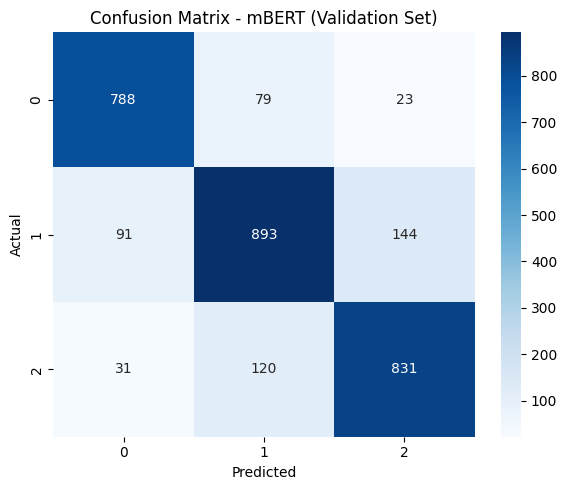

In [ ]:
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Move model to correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# 2. Create DataLoader for validation set (batching to avoid OOM)
val_loader = DataLoader(val_dataset, batch_size=32)

# 3. Store predictions and true labels
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels']  # keep on CPU

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1).cpu()

        all_preds.extend(preds.numpy())
        all_labels.extend(labels.numpy())

# 4. Evaluation Metrics
accuracy = accuracy_score(all_labels, all_preds)
report = classification_report(all_labels, all_preds, target_names=[str(c) for c in le.classes_])
conf_matrix = confusion_matrix(all_labels, all_preds)

# 5. Print Metrics
print(f"\n✅ Validation Accuracy: {accuracy:.4f}")
print("\n📊 Classification Report:\n", report)
print("\n🧮 Confusion Matrix:\n", conf_matrix)

# 6. Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=[str(c) for c in le.classes_],
            yticklabels=[str(c) for c in le.classes_])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - mBERT (Validation Set)")
plt.tight_layout()
plt.show()
